# Interest Rate Curves 

A $n\times 1$ swap is a swap that changes $n$ 

$$
    V_{fixed} = V_{floating}
$$

Where
$$
    V_{fixed} = \sum_{k=1}^{n}r_n\tau_n
$$

### TIIE28

In [1]:
%matplotlib inline
from datetime import datetime, timedelta
import numpy as np
import matplotlib.pyplot as plt
from pyrate import RateCurves

# Load the holidays
holidays = []
with open("files/holidays.txt", "r") as f:
    dates = f.read().split("\n")
    for date in dates:
        holidays.append(datetime.strptime(date, "%m/%d/%y"))

# Initialize the curve 
# The constant coupon rates for nx1 swaps trading liquid in the market
mid_mkt = np.array([0.0409 ,  0.04315,  0.0446 ,  0.046  ,  0.04765,  0.05035,
                    0.05245,  0.0543 ,  0.05605,  0.05905,  0.06215,  0.06401,
                    0.0668 ,  0.06911,  0.07142])

# 'n' flows of of a variable rate v.s. one fixed rate
nx1_instruments = np.array([1, 3, 6, 9, 13, 26, 39, 52, 65, 91, 130, 156, 195, 260, 390])

val_date = datetime(2016, 6, 27)
tiie28 = RateCurves(val_date, mid_mkt, nx1_instruments, 28, holidays)

In [97]:
# Pricing the fixed rate swap
r, n = tiie28.market_coupons[1], tiie28.number_flows[1]
coupon_days = tiie28.length_flows(n).cumsum()

tau_k = tiie28.length_flows(n) / 360
rate_k = tiie28.rate_curve(coupon_days)
discount_factor = 1 / (1 + rate_k * coupon_days / 360)

np.sum(r * tau_k * discount_factor) + discount_factor[-1]

1.0000000017052875

In [68]:
# Pricing the variable rate swap
discount_factor

array([ 0.99682898,  0.99349372,  0.98999772])

In [82]:
(1 / discount_factor[0] - 1) / tau_k[0]

0.040899992549419437

In [94]:
1 - discount_factor[-1]

0.010002284737701594

In [2]:
print(tiie28.discount_rates)
print(tiie28.fitted_curve)

[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
False


In [3]:
tiie28.fit_curve()
print(tiie28.discount_rates)
print(tiie28.fitted_curve)

[ 0.04089999  0.04330003  0.04500234  0.04668823  0.0487722   0.05300998
  0.05695582  0.06097714  0.06527678  0.07444921  0.08906129  0.10105983
  0.12491065  0.16995148  0.31693922]
True


In [4]:
tiie28.days_to_pillar

array([   28,    84,   169,   252,   364,   728,  1092,  1456,  1820,
        2548,  3640,  4368,  5460,  7280, 10920])

In [5]:
from scipy.interpolate import interp1d

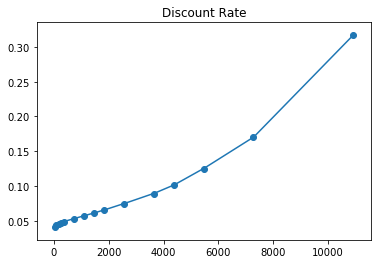

In [98]:
x = np.arange(28, 10920)
plt.plot(x, tiie28.rate_curve(x)) 
plt.scatter(tiie28.days_to_pillar, tiie28.rate_curve(tiie28.days_to_pillar))
plt.title("Discount Rate");

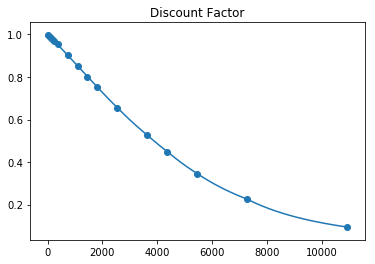

In [7]:
x = np.arange(28, 10920)
plt.plot(x, 1 /( 1 + tiie28.rate_curve(x) * x / 360))
plt.scatter(tiie28.days_to_pillar, 1 /( 1 + tiie28.rate_curve(tiie28.days_to_pillar) * tiie28.days_to_pillar / 360))
plt.title("Discount Factor");